In [1]:
import pandas as pd
from top2vec import Top2Vec
from ast import literal_eval
from tqdm import tqdm
from nltk import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument 
from scipy.spatial.distance import cosine
import os

/Users/mstudio/miniconda3/envs/py3.10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/mstudio/miniconda3/envs/py3.10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/mstudio/miniconda3/envs/py3.10/lib/python3.10/site-packag

In [3]:
# first=pd.read_csv('/Volumes/T7/chroniclingamerica/american-stories/keywords/kkk-first-label.csv')
# between=pd.read_csv('/Volumes/T7/chroniclingamerica/american-stories/keywords/kkk-between-label.csv')
second=pd.read_csv('/Volumes/T7/chroniclingamerica/american-stories/keywords/kkk-second-label-lemma.csv', converters={'token':literal_eval})

In [2]:
accessible_df=pd.read_csv('/Volumes/T7/chroniclingamerica/american-stories/keywords/kkk-accessible-lemma.csv', converters={'token':literal_eval})

In [4]:
accessible_df=accessible_df.sort_values(by='date')

In [5]:
second=second.sort_values(by='date')

In [6]:
data=second['lemma']
len(data)

46613

In [7]:
second[['newspaper_name', 'date', 'article', 'label']]

,newspaper_name,date,article,label
1203,The fool-killer.,1915-01-01,when you have read the con-\ntents of this iss...,neither
423,The Washington times.,1915-01-01,"81 wizard mop\ncombination, 49c =\none 7ac tri...",neither
422,The Washington times.,1915-01-01,congressman george white of ohio.\ndemocrat. h...,neither
774,The Washington herald.,1915-01-01,"telluride, colo, dec. 31.-city marshal\ntyler ...",neither
1027,The Ordway new era.,1915-01-01,~ sas t=-\nleft careiessly thrust into the wal...,neither
...,...,...,...,...
44957,Twin-City herald.,1939-12-30,"los angeles, dec, (cna)-the ku\nklux klan ride...",neither
45348,Evening star.,1939-12-31,the dock was obviously an american.\n\n\nthe s...,neither
45549,Evening star.,1939-12-31,to north carolina after a sever ill\nness in a...,neither
45233,Evening star.,1939-12-31,war on land\n\n\nfighting in the eerie half-lg...,neither


In [8]:
second['label'].unique()

array(['neither', 'ws', 'aa'], dtype=object)

In [9]:
accessible_df['label']='aa'

In [10]:
accessible_df_concat = accessible_df[['filename', 'date', 'article', 'label']]
accessible_df_concat.rename(columns={'filename':'newspaper_name'}, inplace=True)

/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1835/752411281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accessible_df_concat.rename(columns={'filename':'newspaper_name'}, inplace=True)


In [11]:
concat_data=pd.concat([accessible_df_concat, second[['newspaper_name', 'date', 'article', 'label']]])

In [12]:
data=concat_data['article']
len(data)

55543

In [13]:
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(data)]

In [14]:
model = Doc2Vec(vector_size=300, min_count=1, epochs=50)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
#7m 20s
#50m 23s

In [15]:
# get the document vectors
document_vectors = [model.infer_vector(word_tokenize(doc.lower())) for doc in data]
#14m 58s

In [16]:
len(document_vectors)

55543

In [17]:
cosine_sim=[]
for idx, val in enumerate(document_vectors):
    if idx==0:
        continue
    else: 
        cosine_sim.append(cosine(val, document_vectors[idx-1]))

In [18]:
len(cosine_sim)

55542

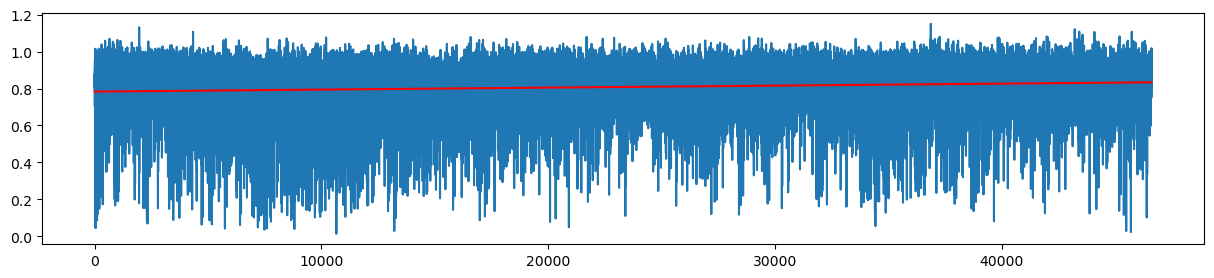

In [66]:
import matplotlib.pyplot as plt
import numpy as np
x=range(0,46612)
y=cosine_sim
plt.figure(figsize=(15,3))
plt.plot(cosine_sim)
slope, intercept = np.polyfit(x, y, 1)
trendline = slope * np.array(x) + intercept
plt.plot(x, trendline, label='Trend Line', color='red')
plt.show()

In [23]:
import umap
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
# digits = load_digits()

embedding = umap.UMAP().fit_transform(document_vectors)

In [20]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(embedding.data)

In [25]:
label_to_color = {'neither': 'grey', 'aa': 'red', 'ws': 'blue'}
# Function to map labels to colors
def map_labels_to_colors(label):
    return label_to_color.get(label, 'unknown')  # Default to 'unknown' if label not found

# Create the 'color' column
concat_data['color'] = concat_data['label'].apply(map_labels_to_colors)

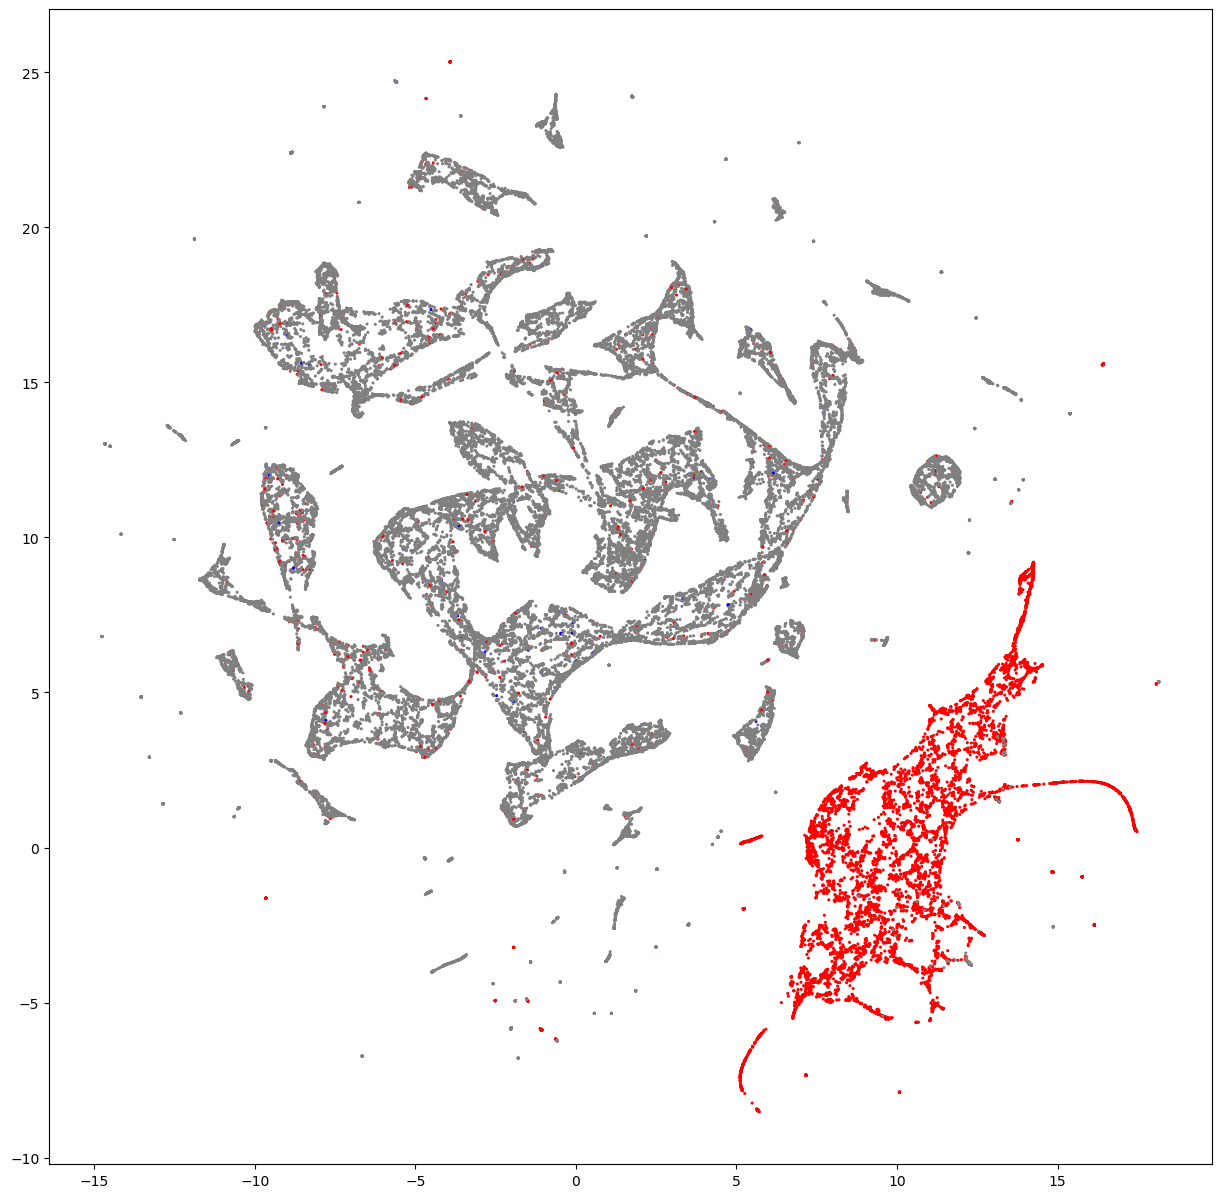

In [27]:
plt.figure(figsize=(15,15))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=1.5, c=concat_data['color'])